In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat, lit, avg, round, unix_timestamp, when, split
from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime


spark = SparkSession.builder.master('local[*]').getOrCreate()

sc = spark.sparkContext

spark

# Authors:
## Victoria Anguix López, María Ferrero Medina, Lara Monteserín Placer

### We have commented every action performed during the development of the code to reduce to the minimum the execution time
To know the number of cores that are being used to execute:

In [2]:
spark.sparkContext.defaultParallelism

4

We load the dataframe:

In [10]:
 df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017_01.csv")

We count the rows to verify the size of the dataset.

This is the amount of data that is being processed. It will be used to calculate the processing speed later.

In [13]:
data_processed = df.count()

For development purposes, we have been using a new dataframe "small", although the final execution has been done using the whole dataframe. Here, a single file of 1000 rows is created

In [5]:
!rm -r small
df.limit(10000).write.option("header", True).option("timestampFormat","yyyy-MM-dd HH:mm:ss").csv("small")   #specifying the csv is necessary

## CASE STUDIES
- Tips depending on the route
- Average speed of taxis in terms of the hour.
- Average trip distance group by number of passengers (depending on the number of passengers)

### 1. Tips depending on the route (based on PULocation and DOLocation) 

#### Solution implemented using dataframes

First, we read the csv to be used applying dataframes

In [6]:
df3 = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017_01.csv")

To visualize the data, we list all columns that are part of the file

In [7]:
#df3.printSchema()

For a better visualization, we transform the dataframe into a Pandas object

In [8]:
#df_pandas = df3.toPandas()

In [9]:
#df3 = spark.createDataFrame(df_pandas)

We read another dataframe that contains the data associating the location IDs with their names

In [10]:
df_locations = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("taxi+_zone_lookup.csv")

We select the columns we are interested in from the location dataset: LocationID and Borough

In [11]:
columns_loc = df_locations.select("LocationID", "Borough")
#columns_loc.show(5)

Now we join the original and the locations dataframes where the Location IDs match (DOLocationID = LocationID, and later we perform the join with the PULocationID column) 

In [12]:
df_join = df3.join(columns_loc, df3["DOLocationID"] == columns_loc["LocationID"])
#df_join.printSchema()

We renamed the chosen "Borough" column as "ArrivalZone" and delete the columns we do not want anymore: LocationID and DOLocationID

In [13]:
df_join = df_join.withColumnRenamed("Borough", "ArrivalZone")

In [14]:
df_join = df_join.drop("LocationID", "DOLocationID")
#df_join.printSchema()

Now, we perform a second join to combine both dataframes where PULocationID = LocationID. We rename the "Borough" column as the "DepartureZone" and delete the columns we do not want anymore: LocationID and PULocationID

In [15]:
final_df = df_join.join(columns_loc, df_join["PULocationID"] == columns_loc["LocationID"])
#final_df.printSchema()

In [16]:
final_df = final_df.withColumnRenamed("Borough", "DepartureZone")

In [17]:
final_df = final_df.drop("LocationID", "PULocationID")
#final_df.printSchema()

Finally, we unify columns DepartureZone and ArrivalZone in a column named route and we delete the columns we do not want anymore: ArrivalZone and DepartureZone

In [18]:
final_df = final_df.withColumn("route", concat(final_df.DepartureZone, lit(" "), final_df.ArrivalZone))
#final_df.show()

In [19]:
final_df = final_df.drop("ArrivalZone", "DepartureZone")
#final_df.printSchema()

Now, the data is ready: we have the routes followed by the passengers. We create a new dataframe "study_1" only with the columns needed to perform the study: Tip_amount and route

In [20]:
study_1 = final_df.select("Tip_amount", "route")
#study_1.show(5)

To complete the first study, we have decided to calculate the average of tips paid by the passengers on the route.

The steps that have been followed are:
- groupBy(): In order to classify the tips based on the route
- agg(): An aggregate function to calculate the average using avg()
- orderBy(): To sort the tips in descending order

In [21]:
avg_tips = study_1.groupBy('route').agg(round(avg('Tip_amount'), 2).alias('Average_Tip_per_Route')).orderBy('Average_Tip_per_Route', ascending=False)

Finally, we show the results and calculate the execution time

In [22]:
start = time.time()
avg_tips.show() #as it is he action --> measure execution time here
end = time.time()
exec_time = end  - start
print("Execution time study 1: ", exec_time)

+--------------------+---------------------+
|               route|Average_Tip_per_Route|
+--------------------+---------------------+
|           Bronx EWR|                 91.6|
|Staten Island Man...|                18.39|
|       EWR Manhattan|                16.05|
|        EWR Brooklyn|                 15.0|
|             EWR EWR|                13.18|
|         Unknown EWR|                10.69|
|          Queens EWR|                 9.97|
|       Manhattan EWR|                 9.35|
|        Brooklyn EWR|                 8.59|
|      Queens Unknown|                 7.77|
|    Brooklyn Unknown|                  6.7|
|    Queens Manhattan|                 6.67|
|Manhattan Staten ...|                 6.41|
|      Bronx Brooklyn|                 5.49|
|     Queens Brooklyn|                 5.06|
|Queens Staten Island|                 4.23|
|    Unknown Brooklyn|                  4.1|
|    Manhattan Queens|                 3.76|
|   Manhattan Unknown|                 3.75|
|        Q

We also transform the data into Pandas in order to plot the results 

In [23]:
'''
avg_tips_pd = avg_tips.toPandas()

plt.figure(figsize=(10,6))

plt.barh(avg_tips_pd["route"], avg_tips_pd["Average_Tip_per_Route"])
plt.xlabel("Average Tips")
plt.ylabel("Route")
plt.title("Average Tip per Route")
'''

'\navg_tips_pd = avg_tips.toPandas()\n\nplt.figure(figsize=(10,6))\n\nplt.barh(avg_tips_pd["route"], avg_tips_pd["Average_Tip_per_Route"])\nplt.xlabel("Average Tips")\nplt.ylabel("Route")\nplt.title("Average Tip per Route")\n'

## 2. Average speed of taxis in terms of the hour.
 

### 2.1 Solution implemented using RDDs

For this purpose we need:
- trip_distance (distance covered by the taxi in a certain route)
- tpep_dropoff_datetime - tpep_pickup_datetime (time of a certain route)
- tpep_pickup_datetime (taken as the hour to compare speeds)

We load the data in a RDD, count the number of rows and show the structure

By default, the number of partitions is 2 (which is the uncommented approach).

Anyway, we want to see if changing the number of partitions changes the execution time for a specific number of cores. So, using our maximum number of cores (8), we will try 3 approaches:
- 4 partitions
- 8 partitions
- 16 partitions (doubling the number of cores)

In [24]:
rdd = sc.textFile("tripdata_2017_01.csv")

#rdd = sc.textFile("tripdata_2017_01.csv", 4)
#rdd = sc.textFile("tripdata_2017_01.csv", 8)
#rdd = sc.textFile("tripdata_2017_01.csv", 16)

In [25]:
#rdd.count()

In [26]:
#rdd.take(8)

First, we filter the header to get the data we are going to access.
Also, we remove the rows with empty data

In [27]:
header = rdd.first()
rdd = rdd.filter(lambda x: x != header).filter(lambda x: x != '')
#rdd.take(8)

Then, we divide the data in columns (by splitting by the ,) and select the three columns we will use, obtaining a list of 3 elements tuples with values of distances (index 4), pickup times (index 1) and dropoff times (index 2)


In [28]:
selected_columns_rdd = rdd.map(lambda x: (x.split(",")[4], x.split(",")[1], x.split(",")[2]))
selected_columns_rdd.take(8)

[('3.30', '2017-01-09 11:13:28', '2017-01-09 11:25:45'),
 ('.90', '2017-01-09 11:32:27', '2017-01-09 11:36:01'),
 ('1.10', '2017-01-09 11:38:20', '2017-01-09 11:42:05'),
 ('1.10', '2017-01-09 11:52:13', '2017-01-09 11:57:36'),
 ('.02', '2017-01-01 00:00:00', '2017-01-01 00:00:00'),
 ('.50', '2017-01-01 00:00:02', '2017-01-01 00:03:50'),
 ('7.75', '2017-01-01 00:00:02', '2017-01-01 00:39:22'),
 ('.80', '2017-01-01 00:00:03', '2017-01-01 00:06:58')]

To calculate the duration of the trips, we do the substraction operation between dropoff and pickup times and add a new "column" to the rdd with that data
The time is calculated in hours as the distance is in miles, to then calculate the speed as in miles/h

In [29]:
withDurationRDD = selected_columns_rdd.map(lambda row: (row[0], row[1], row[2], (datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S") - datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S")).total_seconds()/ 3600.0))
#withDurationRDD.take(8)

To calculate the speed, we divide the distance by the time, add a new "column" to the rdd with that data and then we keep in the rdd only the columns we need, that are row[1] = hour of service (pick-up time) and row[4]= speed of the taxi (miles per hour). As some trips last 0 (start and finish at the same time), we add an if condition

In [30]:
withSpeedRDD = withDurationRDD.map(lambda row: (row[0], row[1], row[2], row[3], (float(row[0]) / row[3]) if row[3] != 0 else 0.0)) 
date_speed = withSpeedRDD.map(lambda row: (row[1], row[4]))

#date_speed.take(5)

Also, we remove the day from the date as it is not meaningful

In [31]:
hour_speed = date_speed.map(lambda row: (row[0].split(' ')[1], row[1]))
#hour_speed.take(5)

Finally, we order the RDD by the speed, to see the possible relationship between hour and speed

In [32]:
final_rdd = hour_speed.sortBy(lambda x: x[1], ascending = False) #sorting by speed

We show the results

In [33]:
print("pickup_hour, speed")
start = time.time()
final_rdd.collect()
end = time.time()
exec_time = end  - start
print("Execution time study 2, RDDs implementation: ", exec_time)

pickup_hour, speed
Execution time study 2, RDDs implementation:  20.509045124053955


### 2.2 Solution implemented using dataframes

For this implementation, we need the same columns as with the previous one

In [34]:
#df3.printSchema() #list of all columns that are part of the file

First, we select the columns we want


In [35]:
study_2 = df3.select("tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance")
#study_2.show(5)

Then, we create a new column "duration" by susbtracting pickup times from dropoff times
We use the function unix_timestamp to get the outcome in seconds

In [36]:
study_2 = study_2.withColumn('duration_seconds', unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))

duration_df = study_2.withColumn('duration_hours', study_2["duration_seconds"] / 3600)

#duration_df.show(5)

We create the column "speed" by dividing the "trip_distance" and the "duration" columns.
As the distance is in miles and the duration is in hours, the speed will be in miles per hour
We add the when function to avoid null values when dividing by duration = 0

In [37]:
speed_df = duration_df.withColumn('speed', when(duration_df["duration_hours"] == 0, 0)
                                       .otherwise(duration_df["trip_distance"] / duration_df["duration_hours"]))
#speed_df.show(5)

We remove the day from the date as it is not meaningful


In [38]:
# Split the 'tpep_pickup_datetime' column by the space character
split_col = split(speed_df['tpep_pickup_datetime'], ' ')

# Create new columns for date and time
speed_df = speed_df.withColumn("hour", split_col.getItem(1))
#speed_df.show(5)

We drop the columns that we no longer need before ordering the data for computational purposes

In [39]:
# Drop the columns that we no longer need 
final_columns = speed_df.drop("tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "duration_seconds", "duration_hours")
#final_columns.show(5)


Finally, we order by the speed to see the possible relationship between hour and speed

In [40]:
final_study_2 = final_columns.orderBy("speed", ascending = False)
start = time.time()
final_study_2.show()
end = time.time()
exec_time = end  - start
print("Execution time study 2, dataframe implementation: ", exec_time)

+------------------+--------+
|             speed|    hour|
+------------------+--------+
|           73800.0|23:02:31|
|           70560.0|16:35:18|
|           68760.0|19:39:26|
| 62639.99999999999|22:59:52|
|           32760.0|23:48:05|
|           24210.0|20:50:01|
|           22920.0|17:01:09|
|           21600.0|22:46:25|
|20879.999999999996|16:57:12|
|20879.999999999996|21:22:57|
|           20760.0|09:54:42|
|           20760.0|16:01:32|
|           20340.0|08:37:32|
|           19620.0|04:49:02|
|           19260.0|04:21:37|
|           17280.0|01:03:11|
|           16596.0|00:41:06|
|16109.999999999998|00:02:40|
|15840.000000000002|02:49:11|
|           15480.0|19:33:45|
+------------------+--------+
only showing top 20 rows

Execution time study 2, dataframe implementation:  3.036545515060425


### 2.3 Solution implemented using SQL

Once again, we need the same 3 columns
- Using the columns tpep_pickup_datetime and tpep_dropoff_datetime we calculate the duration of the trip (substraction). To do it, we use the function DATEDIFF, that returns the time in seconds.
- From the column tpep_pickup_datetime, we extract the time using DATE_FORMAT as 'hour'. 
- Using the column trip_distance and the duration we calculate the speed, avoiding null values
- We select speed and 'hour'

In [41]:
df3.createOrReplaceTempView('trips') #DESIGN AN ALIAS (a custom name)

In [42]:
start = time.time()
spark.sql("""
    SELECT *
    FROM (
        SELECT 
            trip_distance / (DATEDIFF(SECOND, tpep_pickup_datetime, tpep_dropoff_datetime) / 3600) AS speed,
            DATE_FORMAT(tpep_pickup_datetime, 'HH:mm:ss') AS hour
        FROM trips
    )
    WHERE speed IS NOT NULL
    ORDER BY speed DESC
""").show()
end = time.time()
exec_time = end  - start
print("Execution time study 2, SQL implementation: ", exec_time)

+------------------+--------+
|             speed|    hour|
+------------------+--------+
|           73800.0|23:02:31|
|           70560.0|16:35:18|
|           68760.0|19:39:26|
| 62639.99999999999|22:59:52|
|           32760.0|23:48:05|
|           24210.0|20:50:01|
|           22920.0|17:01:09|
|           21600.0|22:46:25|
|20879.999999999996|16:57:12|
|20879.999999999996|21:22:57|
|           20760.0|09:54:42|
|           20760.0|16:01:32|
|           20340.0|08:37:32|
|           19620.0|04:49:02|
|           19260.0|04:21:37|
|           17280.0|01:03:11|
|           16596.0|00:41:06|
|16109.999999999998|00:02:40|
|15840.000000000002|02:49:11|
|           15480.0|19:33:45|
+------------------+--------+
only showing top 20 rows

Execution time study 2, SQL implementation:  3.942714214324951


## 3. Average trip distance depending on the number of passengers

### Solution implemented using SQL

For this, we need:
- trip_distance
- passenger_count

Once selected, we need to calculate the average distances for every different number of passengers (grouping by the passengers number). We remove the data for 0 passengers as it does not make sense for the interpretation of taxi trips data.


In [43]:
df3.createOrReplaceTempView('trips') #DESIGN AN ALIAS (a custom name)

In [44]:
start = time.time()
spark.sql("SELECT passenger_count, AVG(trip_distance), MAX(trip_distance), MIN(trip_distance) FROM trips WHERE passenger_count !=0 GROUP BY passenger_count ORDER BY passenger_count").show()
end = time.time()
exec_time = end  - start
print("Execution time study 3: ", exec_time)

+---------------+------------------+------------------+------------------+
|passenger_count|avg(trip_distance)|max(trip_distance)|min(trip_distance)|
+---------------+------------------+------------------+------------------+
|              1| 2.995511475864654|             120.6|               0.0|
|              2|   3.1123642396984|              86.3|               0.0|
|              3| 3.045738847281015|            139.17|               0.0|
|              4| 3.087570436042792|             151.7|               0.0|
|              5|3.1499190421663785|             50.15|               0.0|
|              6|3.1370771564503857|              79.0|               0.0|
|              7|               0.0|               0.0|               0.0|
|              8|               0.0|               0.0|               0.0|
|              9|               0.0|               0.0|               0.0|
+---------------+------------------+------------------+------------------+

Execution time study 3: 

## 4. Results

### 4.1 Execution times
We save in lists the values of the execution time of every implementation of the 3 studies for every number of available cores (1, 2, 3 or 4) and plot the results

In [26]:
#Keeping execution time in every execution
exec_times_1 = [3.3378396034240723,2.3377509117126465,2.236996650695801,2.1290998458862305,1.8683526515960693,1.8208472728729248,1.9524621963500977,1.928175449371338] #with every different number of cores
exec_times_2_1 = [25.526318311691284,16.14290690422058,11.482961893081665,12.153632164001465,12.354135513305664,11.921333074569702,12.73586392402649,12.244611024856567]#RDD
exec_times_2_2 = [4.21743631362915,2.58328914642334,2.292405605316162,2.2860047817230225,2.1757242679595947,1.7817332744598389,1.967207431793213,2.1478772163391113]#dataframes
exec_times_2_3 = [4.309316873550415,2.8333113193511963,2.794114112854004,2.3724422454833984,2.381791114807129,2.024615526199341,1.9099664688110352,2.079253911972046]#SQL
exec_times_3 = [2.1889734268188477,1.4472410678863525,1.0829746723175049,1.136519193649292,1.0748541355133057,1.1149506568908691,1.1417241096496582,0.9539737701416016]

cores_num = np.arange(1,9)

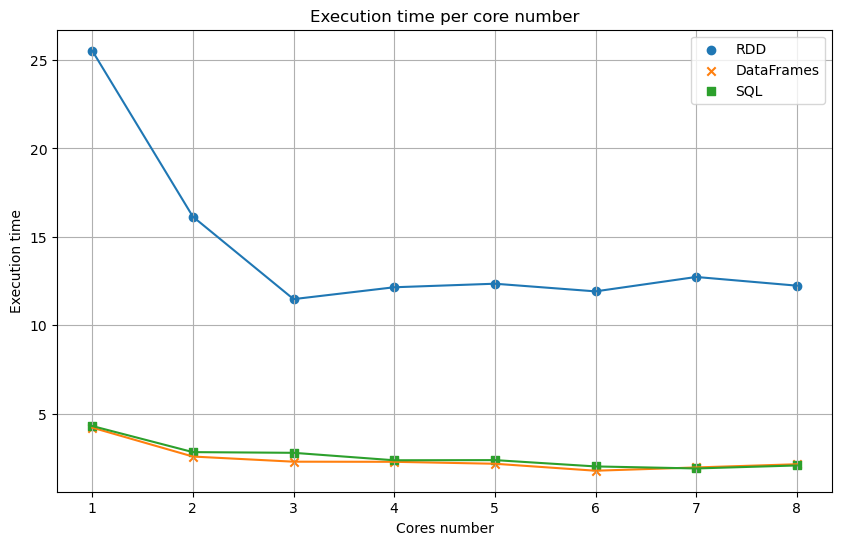

In [27]:
plt.figure(figsize=(10, 6)) 
plt.scatter(cores_num, exec_times_2_1, label='RDD', marker='o') 
plt.scatter(cores_num, exec_times_2_2, label='DataFrames', marker='x')
plt.scatter(cores_num, exec_times_2_3, label='SQL', marker='s')

plt.plot(cores_num, exec_times_2_1, '-')
plt.plot(cores_num, exec_times_2_2, '-')
plt.plot(cores_num, exec_times_2_3, '-')

    
plt.xlabel('Cores number')
plt.ylabel('Execution time')
plt.title('Execution time per core number')
plt.legend()
plt.grid(True)
plt.show()

### 4.2 Calculating processing speeds based on amount of data processed

In [20]:
speed_2_1 = [data_processed/x for x in exec_times_2_1]
speed_2_2 = [data_processed/x for x in exec_times_2_2]
speed_2_3 = [data_processed/x for x in exec_times_2_3]

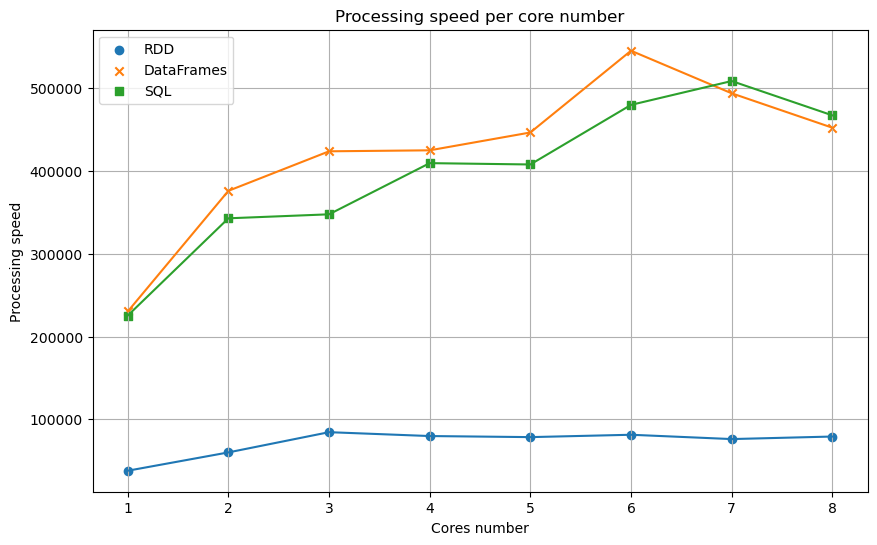

In [28]:
plt.figure(figsize=(10, 6)) 
plt.scatter(cores_num, speed_2_1, label='RDD', marker='o') 
plt.scatter(cores_num, speed_2_2, label='DataFrames', marker='x')
plt.scatter(cores_num, speed_2_3, label='SQL', marker='s')

plt.plot(cores_num, speed_2_1, '-')
plt.plot(cores_num, speed_2_2, '-')
plt.plot(cores_num, speed_2_3, '-')

    
plt.xlabel('Cores number')
plt.ylabel('Processing speed')
plt.title('Processing speed per core number')
plt.legend()
plt.grid(True)
plt.show()

## 4.3 Calculation of the speedup

A common way of measuring how performance improves with the number of cores is the speedup.
Here, it is calculated for the three different approaches in study 2 by dividing the execution time for 1 core and the execution time for n cores.

In [36]:
speedup_2_1 = [exec_times_2_1[0]/x for x in exec_times_2_1]
speedup_2_2 = [exec_times_2_2[0]/x for x in exec_times_2_2]
speedup_2_3 = [exec_times_2_3[0]/x for x in exec_times_2_3]

2.222973353858342


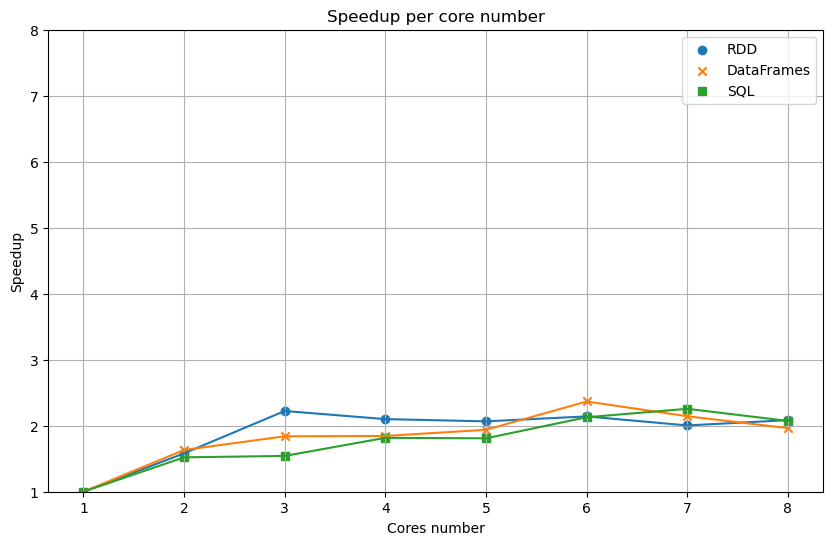

In [40]:
plt.figure(figsize=(10, 6)) 
plt.scatter(cores_num, speedup_2_1, label='RDD', marker='o') 
plt.scatter(cores_num, speedup_2_2, label='DataFrames', marker='x')
plt.scatter(cores_num, speedup_2_3, label='SQL', marker='s')

plt.plot(cores_num, speedup_2_1, '-')
plt.plot(cores_num, speedup_2_2, '-')
plt.plot(cores_num, speedup_2_3, '-')

print(speedup_2_1[2])
    
plt.xlabel('Cores number')
plt.ylabel('Speedup')
plt.ylim(1, 8)
plt.title('Speedup per core number')
plt.legend()
plt.grid(True)
plt.show()

## 4.4 Comparing execution times for a different number of partitions

For the RDD implementation, that is the slowest, we have compared the execution time depending on the number of partitions.

In [29]:
exec_times_partitions = [12.244611024856567,9.830851554870605,8.642735481262207, 9.576157569885254]
n_partitions = [2,4,8,16]

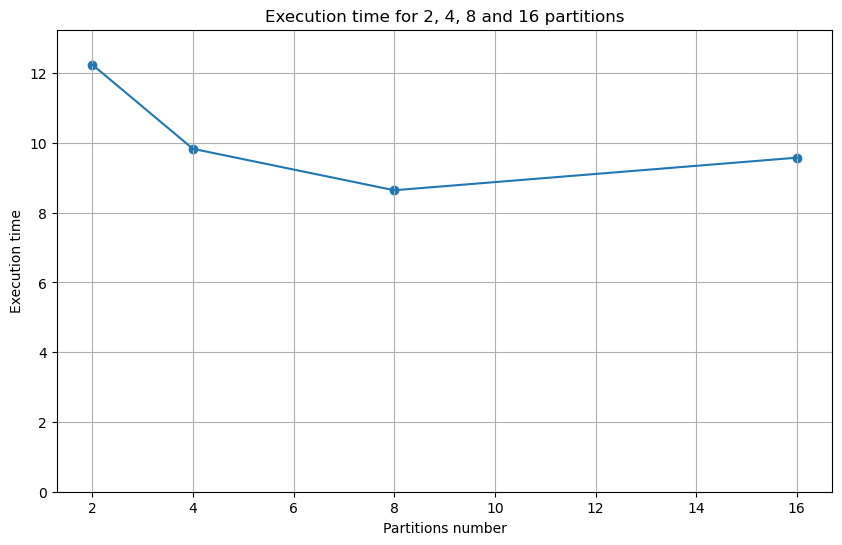

In [33]:
plt.figure(figsize=(10, 6)) 
plt.scatter(n_partitions, exec_times_partitions, marker='o') 

plt.plot(n_partitions, exec_times_partitions, '-')
    
plt.xlabel('Partitions number')
plt.ylabel('Execution time')
plt.ylim(0,max(exec_times_partitions)+1)
plt.title('Execution time for 2, 4, 8 and 16 partitions')
plt.grid(True)
plt.show()

## 5. Conclusions

The execution times and the processing speeds have been calculated for every implementation of study 2, so that the differences between RDDs, dataframes and SQL queries can be perceived.

In the graphs above both parameters show better performance for the SQL and dataframes implementations compared to the RDDs approach. Opposite to what it can be thought in the first place, working with lower level implementations does not provide better outcomes in terms of performance.

Also, regarding the number of cores, a decrease in the execution times can be seen until a plateau is reached when the number of cores arrives to 3. This happens because of the overhead planning and means that it is not computationally cost-effective to increase the number of cores (use more resources) between 3 and the maximum (8), as the performance will not improve.

About the speedup, accordingly with the previous conclusions, it reaches its maximum when using 3 cores, obtaining overhead for a greater number of cores. The maximum speedup for 3 cores is obtained with RDDs and its value is 2.22297.

Finally, it has been checked that the execution time is affected by the number of partitions until we partition over the maximum number of cores. This means that, in descending order of performance, the number of partitions goes like the following: 8, 16, 4, 2. The best option then is to use the same number of partitions and cores. So, in this case, the best results are achieved for 8 partitions (as we have 8 cores).